<a href="https://colab.research.google.com/github/odango314159/caTech/blob/main/VoiceRecsample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!mkdir ./voice_data
!git clone https://github.com/karolpiczak/ESC-50 ./voice_data

Cloning into './voice_data'...
remote: Enumerating objects: 4196, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 4196 (delta 38), reused 31 (delta 14), pack-reused 4136
Receiving objects: 100% (4196/4196), 878.79 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (285/285), done.
Updating files: 100% (2011/2011), done.


In [6]:
!pip install librosa
!pip install seaborn as sns

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [3]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn.functional as F
import librosa
import librosa.display
import IPython.display as ipd

In [7]:
folder_path = './voice_data/'

In [8]:
meta_df = pd.read_csv(folder_path+"meta/esc50.csv")
meta_df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [11]:
categories = meta_df['category'].unique()
print("データセットの数は{}".format(meta_df.shape[0]))
print(len(categories),categories[:10])
print("データセットの形状は{}".format(meta_df.shape))

データセットの数は2000
50 ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']
データセットの形状は(2000, 7)


In [12]:
waveform,sample_rate = librosa.load(folder_path + "audio/1-100032-A-0.wav")

feature_melspec = librosa.feature.melspectrogram(y=waveform,sr=sample_rate)

feature_mfcc = librosa.feature.mfcc(y=waveform,sr=sample_rate)

print("波形データのデータタイプは{}".format(type(waveform)))
print("メルスペクトログラムのデータタイプ{}".format(type(feature_melspec)))
print("MFCCのデータタイプは{}".format(type(feature_mfcc)))
print("サンプルレートは{}".format(sample_rate))
print("波形データの形状は{}".format(waveform.shape))
print("メルスペクトログラムの形状は{}".format(feature_melspec.shape))
print("MFCCの形状は{}".format(feature_mfcc.shape))

波形データのデータタイプは<class 'numpy.ndarray'>
メルスペクトログラムのデータタイプ<class 'numpy.ndarray'>
MFCCのデータタイプは<class 'numpy.ndarray'>
サンプルレートは22050
波形データの形状は(110250,)
メルスペクトログラムの形状は(128, 216)
MFCCの形状は(20, 216)


category : sea_waves


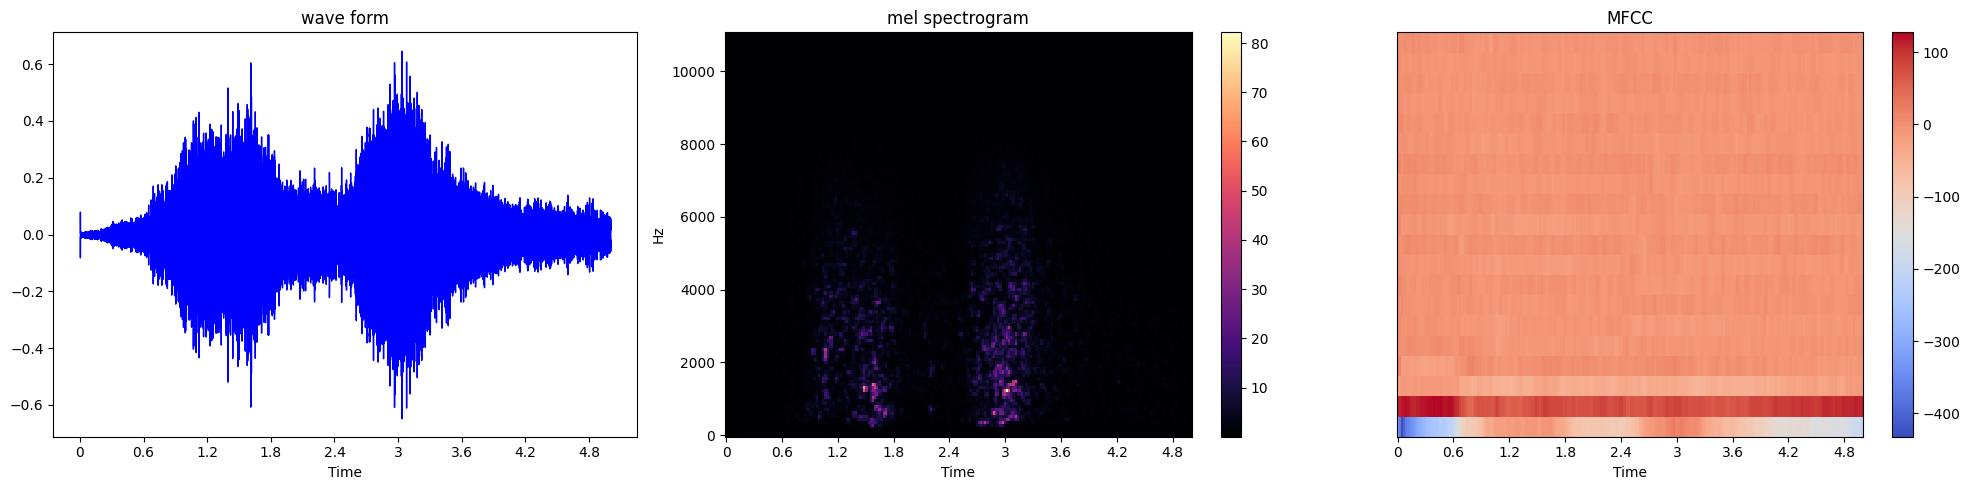

category : coughing


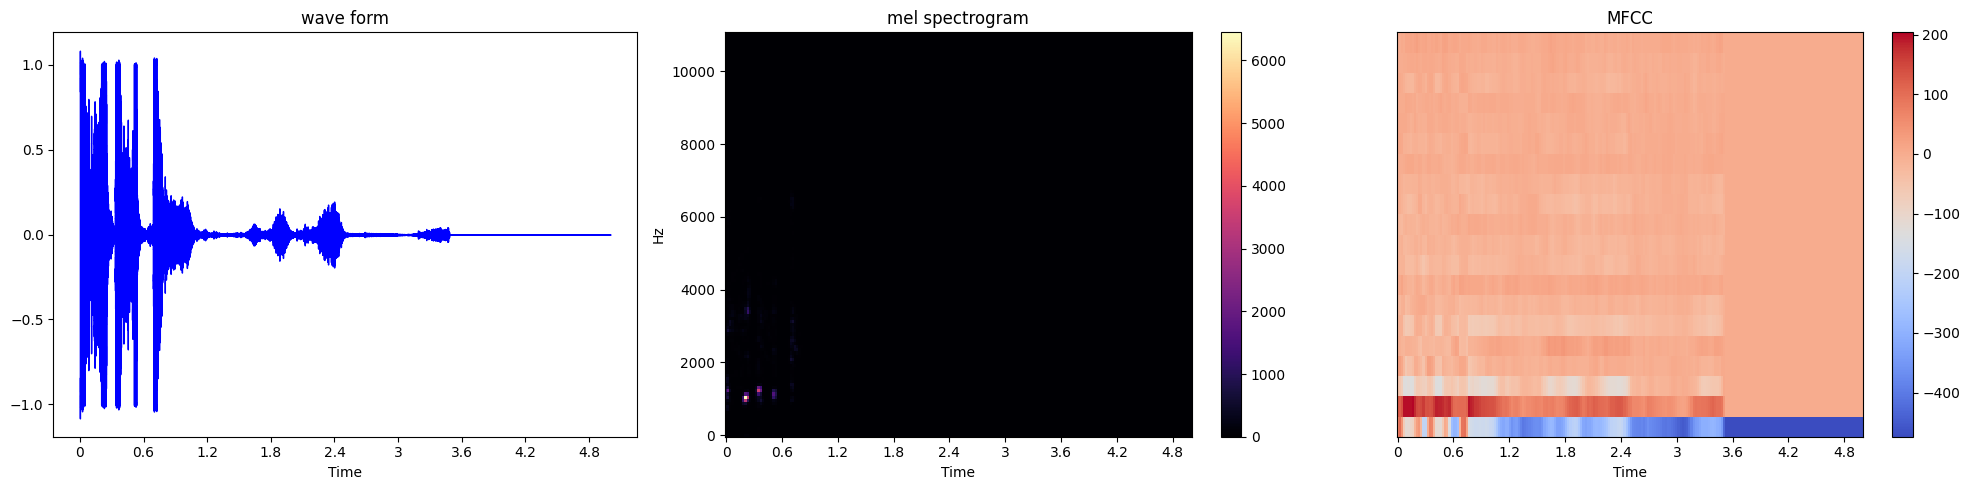

category : glass_breaking


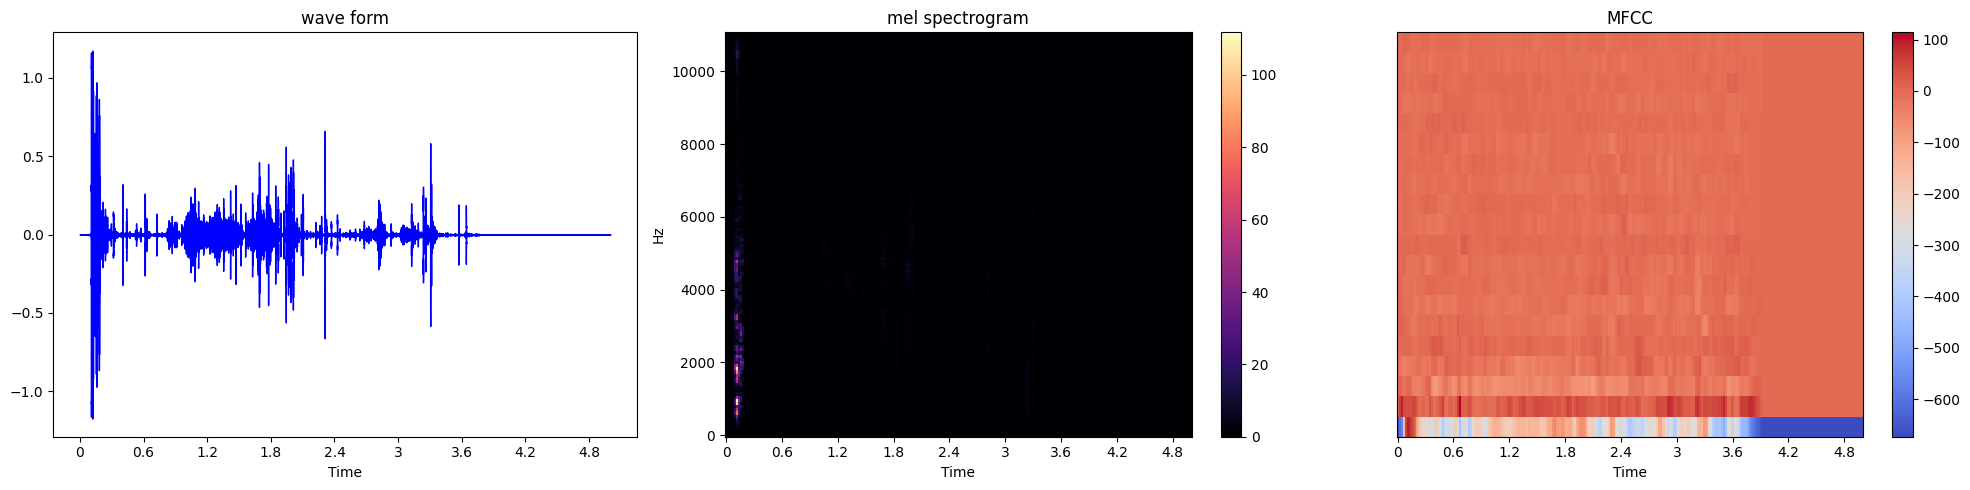

In [15]:
drive_dir = folder_path
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
    filename = row[1][0] # wavファイル名
    category = row[1][1] # そのファイルのカテゴリ

    # 波形データとサンプルレートを取得
    waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)

    # メルスペクトログラムを取得
    feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

    # MFCCを取得
    feature_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)

    # 可視化してみる
    print("category : " + category)
    plt.figure(figsize=(20, 5))

    # librosa.display.waveplotで波形データを可視化できます
    plt.subplot(1,3,1)
    plt.title("wave form")
    librosa.display.waveshow(waveform, sr=sample_rate, color='blue')

    # librosa.display.specshowでメルスペクトログラム、MFCCを可視化できます
    plt.subplot(1,3,2)
    plt.title("mel spectrogram")
    librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title("MFCC")
    librosa.display.specshow(feature_mfcc, sr=sample_rate, x_axis='time')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    print()

    # 音源の再生はlibrosaで取得できた波形データとサンプルレートをIPython.display.Audioに以下のようにして渡します。
    display(ipd.Audio(waveform, rate=sample_rate))

category : door_wood_knock


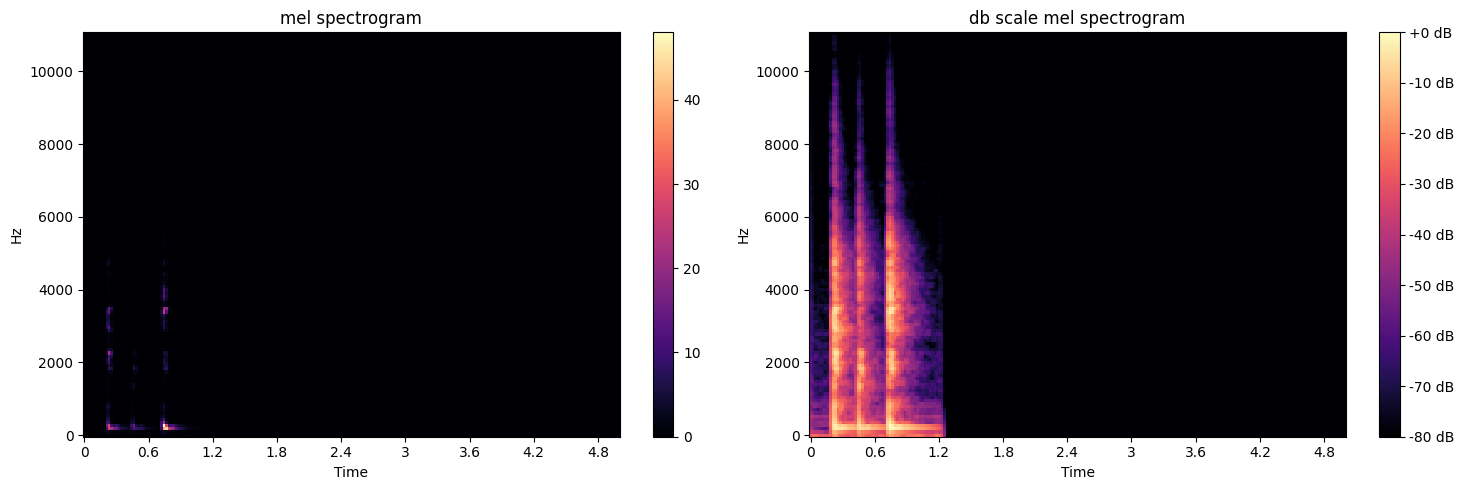

category : crying_baby


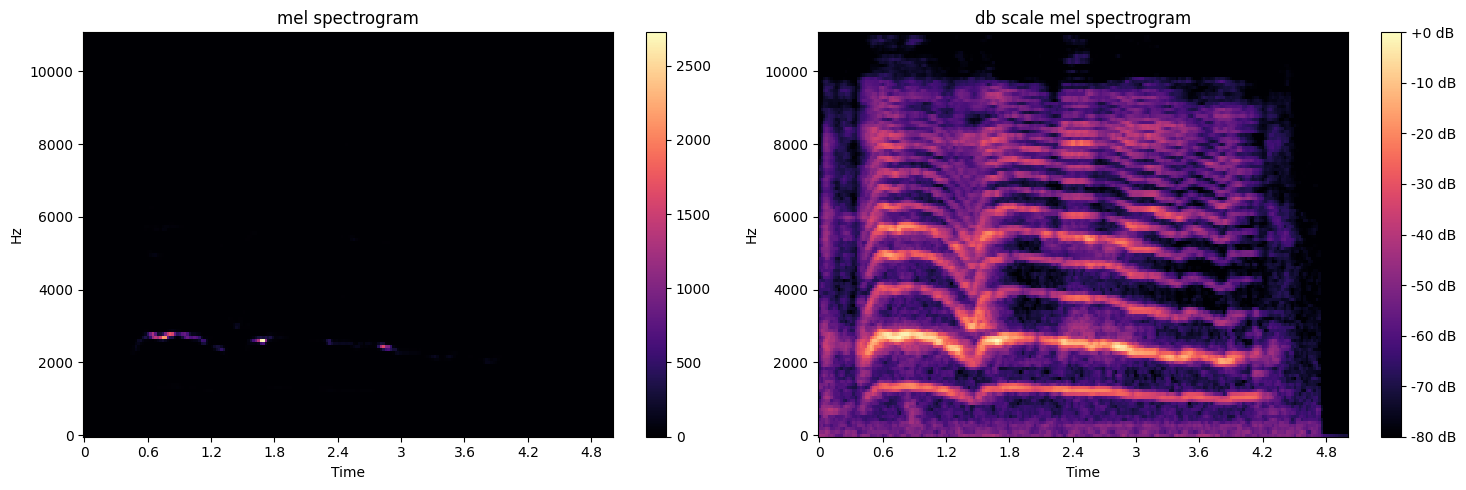

category : clapping


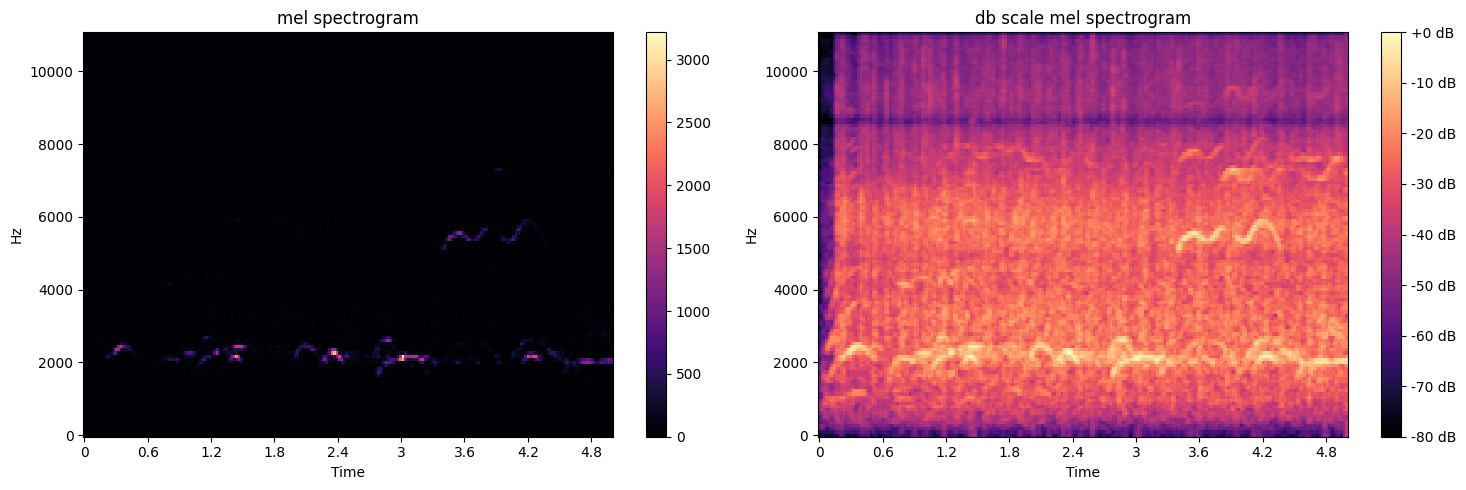

In [16]:
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
    filename = row[1][0] # wavファイル名
    category = row[1][1] # そのファイルのカテゴリ

    waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)

    # メルスペクトログラムを求める
    feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

    print("category : " + category)
    plt.figure(figsize=(15,5))

    # librosa.feature.melspectrogramをそのまま可視化した場合
    plt.subplot(1,2,1)
    plt.title("mel spectrogram")
    librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

    # デシベルスケールに変換した場合
    plt.subplot(1,2,2)
    plt.title("db scale mel spectrogram")
    feature_melspec_db = librosa.power_to_db(feature_melspec, ref=np.max)
    librosa.display.specshow(feature_melspec_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()
